DataFrame loaded. Shape: (3244, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3244 entries, 0 to 3243
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tweet_id       3244 non-null   object 
 1   content        3244 non-null   object 
 2   datetime       3244 non-null   object 
 3   likes          3244 non-null   int64  
 4   shares         3244 non-null   int64  
 5   views          2442 non-null   float64
 6   source         3244 non-null   object 
 7   isBlue         3244 non-null   bool   
 8   followers      3244 non-null   int64  
 9   hashtags       1097 non-null   object 
 10  location       3244 non-null   object 
 11  user_mentions  3244 non-null   object 
 12  media          3244 non-null   object 
 13  username       3244 non-null   object 
 14  url            3244 non-null   object 
 15  comments       3244 non-null   object 
dtypes: bool(1), float64(1), int64(3), object(11)
memory usage: 3

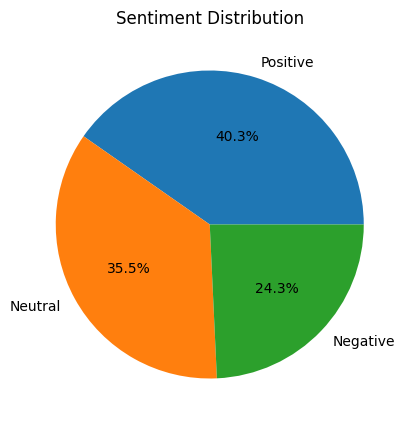

Number of complaint posts: 431


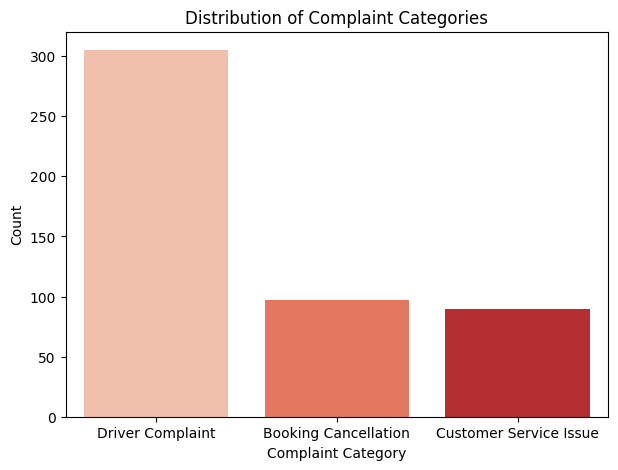

=== 5(a) Correlation Matrix ===
              followers     likes    shares  num_comments
followers      1.000000  0.064813  0.011604      0.104815
likes          0.064813  1.000000  0.357393      0.501219
shares         0.011604  0.357393  1.000000      0.208426
num_comments   0.104815  0.501219  0.208426      1.000000


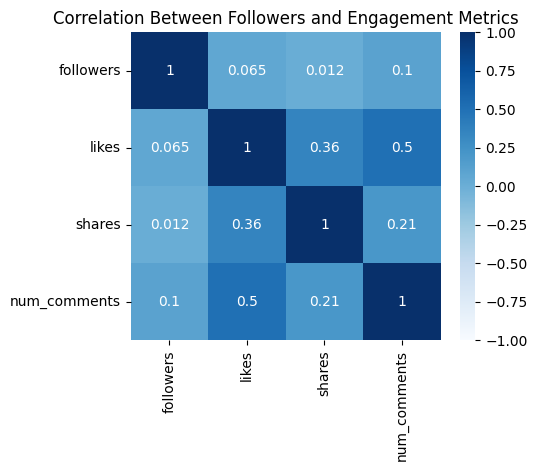


=== 5(b) Average Engagement by Source ===
source
TWITTER    193.913995
Name: total_engagement, dtype: float64


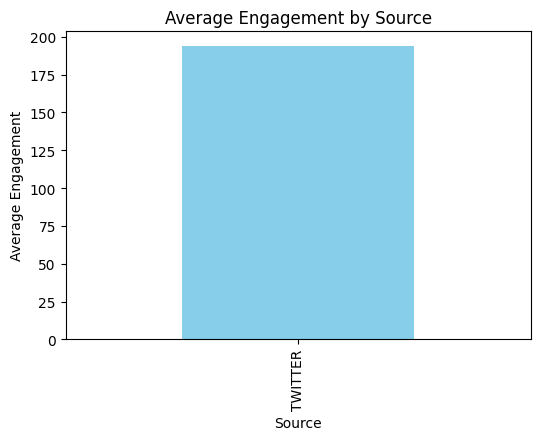

Recommendations for Ola Cabs:
1. Implement stricter driver cancellation policies and offer incentives for drivers to complete accepted rides.
2. Enhance customer care training and set clear resolution metrics to address service-related issues promptly.
3. Develop a platform-specific engagement strategy (e.g., quickly respond to Twitter complaints, use Instagram for brand building).
Cleaned data saved to 'ola_cleaned.csv'.


In [1]:
# Replace 'ola.json' with your actual file path if needed
# Data handling
import json
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment analysis (TextBlob)
# !pip install textblob --quiet  # run this only once in a notebook cell to install
from textblob import TextBlob

# For handling the mode calculation
from statistics import mode

# (Optional) to suppress warnings in a notebook
import warnings
warnings.filterwarnings('ignore')
file_path = 'ola.json'
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

print("DataFrame loaded. Shape:", df.shape)
df.head()
df.info()
# Example: fill `hashtags` if None with an empty list
df['hashtags'] = df['hashtags'].apply(lambda x: x if isinstance(x, list) else [])

# Fill numeric columns like 'views' with 0 if missing
df['views'] = df['views'].fillna(0)

# Ensure likes, shares, views, followers are integers
df['likes'] = df['likes'].astype(int)
df['shares'] = df['shares'].astype(int)
df['views'] = df['views'].astype(int)
df['followers'] = df['followers'].astype(int)

# Convert datetime if it follows 'DD-MM-YYYY HH:MM:SS'
df['datetime'] = pd.to_datetime(df['datetime'], format='%d-%m-%Y %H:%M:%S', errors='coerce')

# Drop rows with no content or tweet_id if they exist
df.dropna(subset=['content', 'tweet_id'], inplace=True)

print("Data cleaned. Shape:", df.shape)
df.head()
print("=== 2(a) Basic Statistics for Engagement Metrics ===")
engagement_metrics = ['likes', 'shares', 'views']

for metric in engagement_metrics:
    # Convert column to numeric if not already (safeguard)
    df[metric] = pd.to_numeric(df[metric], errors='coerce').fillna(0).astype(int)
    
    col_data = df[metric]
    
    # Calculate mean, median, mode. Handle multiple or missing modes gracefully:
    try:
        col_mode = mode(col_data)
    except:
        col_mode = "No unique mode"
    
    print(f"\n--- {metric.upper()} ---")
    print(f"Mean  : {col_data.mean():.2f}")
    print(f"Median: {col_data.median():.2f}")
    print(f"Mode  : {col_mode}")

# 2(b) Identify the top 5 posts with the highest engagement
#     Engagement = likes + shares + number_of_comments

# Count how many comments each post has
df['num_comments'] = df['comments'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Create a total_engagement column
df['total_engagement'] = df['likes'] + df['shares'] + df['num_comments']

# Get the top 5 rows by total_engagement
top_5 = df.nlargest(5, 'total_engagement')

print("\n=== 2(b) Top 5 Posts by Engagement (likes + shares + comments) ===")
print(top_5[['tweet_id', 'content', 'likes', 'shares', 'num_comments', 'total_engagement']])

# 2(c) Count the number of posts with media attachments
df['has_media'] = df['media'].apply(lambda x: len(x) > 0 if isinstance(x, list) else False)
media_count = df['has_media'].sum()

print("\n=== 2(c) Number of posts with media attachments ===")
print("Posts with media:", media_count)
def get_polarity(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df['polarity'] =df['content'].apply(get_polarity)
# df['content'].apply(get_polarity)
def categorize_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['polarity'].apply(categorize_sentiment)
sentiment_dist = df['sentiment'].value_counts(normalize=True) * 100
print("Sentiment Distribution (%):\n", sentiment_dist)

# (Optional) You could plot this distribution as a pie chart
sentiment_dist.plot(kind='pie', autopct='%1.1f%%', figsize=(5,5), title="Sentiment Distribution")
plt.ylabel("")  # hide the y-label
plt.show()
driver_keywords = ['driver', 'drivers']
booking_keywords = ['cancel', 'cancellation', 'cancelled', 'booking']
service_keywords = ['customer care', 'customer service', 'service issue', 'customer support']
def find_complaint_categories(text):
    text_lower = text.lower()
    categories = []
    
    if any(word in text_lower for word in driver_keywords):
        categories.append('Driver Complaint')
    if any(word in text_lower for word in booking_keywords):
        categories.append('Booking Cancellation')
    if any(word in text_lower for word in service_keywords):
        categories.append('Customer Service Issue')
    
    if len(categories) == 0:
        return None
    else:
        return categories

df['complaint_categories'] = df['content'].apply(find_complaint_categories)
complaints_df = df[df['complaint_categories'].notnull()].copy()
print("Number of complaint posts:", complaints_df.shape[0])
complaints_df[['tweet_id', 'content', 'complaint_categories']].head()
from collections import Counter

all_complaints = []
for cat_list in complaints_df['complaint_categories']:
    all_complaints.extend(cat_list)

complaint_counter = Counter(all_complaints)
labels = list(complaint_counter.keys())
counts = list(complaint_counter.values())

plt.figure(figsize=(7,5))
sns.barplot(x=labels, y=counts, palette='Reds')
plt.title("Distribution of Complaint Categories")
plt.xlabel("Complaint Category")
plt.ylabel("Count")
plt.show()
# 5(a) Correlation between the number of followers and engagement metrics
#     We will look at 'followers', 'likes', 'shares', and 'num_comments'.
df['num_comments'] = df['comments'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df['total_engagement'] = df['likes'] + df['shares'] + df['num_comments']
corr_cols = ['followers', 'likes', 'shares', 'num_comments']

# Create a correlation matrix using Pearson correlation
corr_matrix = df[corr_cols].corr(method='pearson')
print("=== 5(a) Correlation Matrix ===")
print(corr_matrix)

# Optional: visualize the correlation with a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1)
plt.title("Correlation Between Followers and Engagement Metrics")
plt.show()

# 5(b) Identify patterns in engagement based on the source of posts
#     We assume there's a 'source' column (e.g., 'TWITTER', 'INSTAGRAM', etc.)
#     and a 'total_engagement' column (likes + shares + num_comments).

engagement_by_source = df.groupby('source')['total_engagement'].mean().sort_values(ascending=False)

print("\n=== 5(b) Average Engagement by Source ===")
print(engagement_by_source)

# Visualize the average engagement by source
plt.figure(figsize=(6,4))
engagement_by_source.plot(kind='bar', color='skyblue')
plt.title("Average Engagement by Source")
plt.ylabel("Average Engagement")
plt.xlabel("Source")
plt.show()
recommendations = [
    "1. Implement stricter driver cancellation policies and offer incentives for drivers to complete accepted rides.",
    "2. Enhance customer care training and set clear resolution metrics to address service-related issues promptly.",
    "3. Develop a platform-specific engagement strategy (e.g., quickly respond to Twitter complaints, use Instagram for brand building)."
]

print("Recommendations for Ola Cabs:")
for rec in recommendations:
    print(rec)
df.to_csv('ola_cleaned.csv', index=False)
print("Cleaned data saved to 'ola_cleaned.csv'.")